In [16]:
import numpy as np
import time


class Linear:
    def __init__(self, m, n):
        self.weight = np.random.randn(m, n) * np.sqrt(2 / m)
        self.bias = np.random.randn(n) * 0.01
        
        self.first_moment = np.zeros((m, n))
        self.second_moment = np.zeros((m, n))
        
        self.bias_first_moment = np.zeros(n)
        self.bias_second_moment = np.zeros(n)
        
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.learning_rate = 1e-4
        
        self.step = 0
        
        self.input = None
        
    def forward(self, input):
        self.input = input
        return np.dot(input, self.weight) + self.bias
    
    def backward(self, output_gradient):
        self.step += 1
        
        input_gradient = np.dot(output_gradient, self.weight.T)
        weight_gradient = np.dot(self.input.T, output_gradient)
        bias_gradient = np.sum(output_gradient, axis=0)
        
        self.first_moment = self.beta1 * self.first_moment + (1 - self.beta1) * weight_gradient
        self.second_moment = self.beta2 * self.second_moment + (1 - self.beta2) * weight_gradient * weight_gradient
        
        self.bias_first_moment = self.beta1 * self.bias_first_moment + (1 - self.beta1) * bias_gradient
        self.bias_second_moment = self.beta2 * self.bias_second_moment + (1 - self.beta2) * bias_gradient * bias_gradient
        
        first_unbias = self.first_moment / (1 - self.beta1 ** self.step)
        second_unbias = self.second_moment / (1 - self.beta2 ** self.step)
        
        bias_first_unbias = self.bias_first_moment / (1 - self.beta1 ** self.step)
        bias_second_unbias = self.bias_second_moment / (1 - self.beta2 ** self.step) 
        
        self.weight -= self.learning_rate * first_unbias / (np.sqrt(second_unbias) + 1e-7)
        self.bias -= self.learning_rate * bias_first_unbias / (np.sqrt(bias_second_unbias) + 1e-7)
        
        return input_gradient
        

class ReLu:
    def __init__(self):
        self.input = None
        
    def forward(self, input):
        self.input = input
        return input * (input > 0)
    
    def backward(self, output_gradient):
        return output_gradient * (self.input > 0)
    

class Softmax:
    def __init__(self):
        self.input = None
        self.output = None
    
    def forward(self, input):
        self.input = input
        max_input = np.max(input, axis=1, keepdims=True)
        exp_input = np.exp(input-max_input)
        self.output = exp_input / np.sum(exp_input, axis=1, keepdims=True)
        
        return self.output
    
    def backward(self, output_gradient):
        return self.output - output_gradient
    
    
def cross_entropy_loss(y_true, y_pred):
    k = y_true.shape[0]
    loss = -np.sum(y_true * np.log(y_pred)) / k
    return loss


class Conv:
    def __init__(self, input_features, out_features, out_height, out_width):
        self.input_features = input_features
        self.out_features = out_features
        self.out_height = out_height
        self.out_width = out_width
        
        self.padding = 1
        self.stride = 1
        self.kernel_height = 3
        self.kernel_width = 3
        
        self.weight = np.random.randn(out_features, self.kernel_height*self.kernel_width*self.input_features) * np.sqrt(2 / (self.kernel_height*self.kernel_width*self.input_features))
        self.bias = np.random.randn(out_features, 1) * 0.01
        
        self.first_moment = np.zeros_like(self.weight)
        self.second_moment = np.zeros_like(self.weight)
        
        self.bias_first_moment = np.zeros_like(self.bias)
        self.bias_second_moment = np.zeros_like(self.bias)
        
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.learning_rate = 1e-3
        
        self.step = 0
        
        self.input_shape = None
        self.input_cols = None
    
    def forward(self, input):
        self.input_shape = input.shape
        self.input_cols = self.img_to_col(input)

        out_cols = np.dot(self.weight, self.input_cols) + self.bias
        return out_cols.reshape(self.out_features, self.out_height, self.out_width, -1).transpose(3, 0, 1, 2)
    
    def backward(self, out_gradient):
        self.step += 1
        
        out_gradient_reshaped = out_gradient.transpose(1, 2, 3, 0).reshape(self.out_features, -1)
        
        weight_gradient = np.dot(out_gradient_reshaped, self.input_cols.T)
        bias_gradient = np.sum(out_gradient_reshaped, axis=1, keepdims=True)
        input_cols_gradient = np.dot(self.weight.T, out_gradient_reshaped)
        input_gradient = self.col_to_img(input_cols_gradient, self.input_shape)
        
        self.first_moment = self.beta1 * self.first_moment + (1 - self.beta1) * weight_gradient
        self.second_moment = self.beta2 * self.second_moment + (1 - self.beta2) * weight_gradient * weight_gradient
        
        self.bias_first_moment = self.beta1 * self.bias_first_moment + (1 - self.beta1) * bias_gradient
        self.bias_second_moment = self.beta2 * self.bias_second_moment + (1 - self.beta2) * bias_gradient * bias_gradient
        
        first_unbias = self.first_moment / (1 - self.beta1 ** self.step)
        second_unbias = self.second_moment / (1 - self.beta2 ** self.step)
        
        bias_first_unbias = self.bias_first_moment / (1 - self.beta1 ** self.step)
        bias_second_unbias = self.bias_second_moment / (1 - self.beta2 ** self.step)
        
        self.weight -= self.learning_rate * first_unbias / (np.sqrt(second_unbias) + 1e-7)
        self.bias -= self.learning_rate * bias_first_unbias / (np.sqrt(bias_second_unbias) + 1e-7)
        
        return input_gradient
        
                
    def img_to_col(self, x):
        zero_x = np.array(x)

        if self.padding > 0:
            # x shapes consist of 4 channels
            zero_x = np.pad(x, [(0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)], mode='constant')

        k, i, j = self.img_to_col_indices(x.shape)

        cols = zero_x[:, k, i, j]
        # change to (kernel_height * kernel_width * channel, output_height * output_width * batch)
        cols = cols.transpose(1, 2, 0).reshape(self.kernel_height * self.kernel_width * x.shape[1], -1)

        return cols

        
    def img_to_col_indices(self, x_shape):
        batch, input_features, input_height, input_width = x_shape

        # i_column correspond to the kernel index
        i_column = np.repeat(np.arange(self.kernel_height), self.kernel_width)
        i_column = np.tile(i_column, self.input_features)

        # i_row correspond to the output index
        i_row = self.stride * np.repeat(np.arange(self.out_height), self.out_width)

        # j_column correspond to the kernel index
        j_column = np.tile(np.arange(self.kernel_width), self.kernel_height * self.input_features)

        # j_row correspond to the output index
        j_row = self.stride * np.tile(np.arange(self.out_width), self.out_height)

        i = i_column.reshape(-1, 1) + i_row.reshape(1, -1)
        j = j_column.reshape(-1, 1) + j_row.reshape(1, -1)

        # This takes into account input features. This is because we have to multiply it as much as input_features.
        k = np.repeat(np.arange(self.input_features), self.kernel_height * self.kernel_width).reshape(-1, 1)

        return k, i, j

    def col_to_img(self, column, x_shape):
        batch, input_features, input_height, input_width = x_shape
        input_height_padded, input_width_padded = input_height + 2 * self.padding, input_width + 2 * self.padding
        x_padded = np.zeros((batch, input_features, input_width_padded, input_height_padded))
        k, i, j = self.img_to_col_indices(x_shape)
        column_reshaped = column.reshape(input_features * self.kernel_height * self.kernel_width, -1, batch)
        column_reshaped = column_reshaped.transpose(2, 0, 1)

        # padded array with column indices k, i, j np.add.at add not duplicately
        np.add.at(x_padded, (slice(None), k, i, j), column_reshaped)

        # padded array to original array
        if self.padding != 0:
            return x_padded[:, :, self.padding:-self.padding, self.padding:-self.padding]

        return x_padded
    
class MaxPooling:
    def __init__(self, input_features, input_height, input_width):
        self.input_features = input_features
        self.input_height = input_height
        self.input_width = input_width
        
        self.padding = 0
        self.stride = 2
        self.kernel_height = 2
        self.kernel_width = 2
        
        self.out_height = self.input_height // self.stride
        self.out_width = self.input_width // self.stride

        self.max_indices = None
        self.input_shape = None
    
    def forward(self, input):
        self.input_shape = input.shape
        input_cols = self.img_to_col(input)
        
        input_cols_reshaped = input_cols.reshape(self.input_features, self.kernel_height * self.kernel_width, -1)

        self.max_indices = np.argmax(input_cols_reshaped, axis=1)
        out_cols = np.max(input_cols_reshaped, axis=1)
        
        return out_cols.reshape(self.input_features, self.out_height, self.out_width, -1).transpose(3, 0, 1, 2)
    
    def backward(self, out_gradient):
        input_gradient_cols_reshaped = np.zeros((self.input_features, self.kernel_height * self.kernel_width, self.out_height * self.out_width * out_gradient.shape[0]))
        
        out_gradient_cols_reshaped = out_gradient.transpose(1, 2, 3, 0).reshape(self.input_features, -1)
        
        for f in np.arange(self.input_features):
            input_gradient_cols_reshaped[f, self.max_indices[f], :] = out_gradient_cols_reshaped[f]
        
        input_gradient = self.col_to_img(input_gradient_cols_reshaped.reshape(self.input_features * self.kernel_height * self.kernel_width, -1), self.input_shape)
        return input_gradient
                
    def img_to_col(self, x):
        zero_x = np.array(x)

        if self.padding > 0:
            # x shapes consist of 4 channels
            zero_x = np.pad(x, [(0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)], mode='constant')

        k, i, j = self.img_to_col_indices(x.shape)

        cols = zero_x[:, k, i, j]
        # change to (kernel_height * kernel_width * channel, output_height * output_width * batch)
        cols = cols.transpose(1, 2, 0).reshape(self.kernel_height * self.kernel_width * x.shape[1], -1)

        return cols

        
    def img_to_col_indices(self, x_shape):
        batch, input_features, input_height, input_width = x_shape

        # i_column correspond to the kernel index
        i_column = np.repeat(np.arange(self.kernel_height), self.kernel_width)
        i_column = np.tile(i_column, self.input_features)

        # i_row correspond to the output index
        i_row = self.stride * np.repeat(np.arange(self.out_height), self.out_width)

        # j_column correspond to the kernel index
        j_column = np.tile(np.arange(self.kernel_width), self.kernel_height * self.input_features)

        # j_row correspond to the output index
        j_row = self.stride * np.tile(np.arange(self.out_width), self.out_height)

        i = i_column.reshape(-1, 1) + i_row.reshape(1, -1)
        j = j_column.reshape(-1, 1) + j_row.reshape(1, -1)

        # This takes into account input features. This is because we have to multiply it as much as input_features.
        k = np.repeat(np.arange(self.input_features), self.kernel_height * self.kernel_width).reshape(-1, 1)

        return k, i, j

    def col_to_img(self, column, x_shape):
        batch, input_features, input_height, input_width = x_shape
        input_height_padded, input_width_padded = input_height + 2 * self.padding, input_width + 2 * self.padding
        x_padded = np.zeros((batch, input_features, input_width_padded, input_height_padded))
        k, i, j = self.img_to_col_indices(x_shape)
        column_reshaped = column.reshape(input_features * self.kernel_height * self.kernel_width, -1, batch)
        column_reshaped = column_reshaped.transpose(2, 0, 1)

        # padded array with column indices k, i, j np.add.at add not duplicately
        np.add.at(x_padded, (slice(None), k, i, j), column_reshaped)

        # padded array to original array
        if self.padding != 0:
            return x_padded[:, :, self.padding:-self.padding, self.padding:-self.padding]

        return x_padded
    

class Flatten:
    def __init__(self):
        self.input = None
        
    def forward(self, input):
        self.input = input
        return input.reshape(self.input.shape[0], -1)
    
    def backward(self, output_gradient):
        return output_gradient.reshape(self.input.shape)
    
        
class NN:
    def __init__(self):
        self.layer = [Linear(784, 256), ReLu(), Linear(256, 256), ReLu(), Linear(256, 10), Softmax()]
    
    def _forward(self, input):
        for i in range(6):
            input = self.layer[i].forward(input)
            
        return input
    
    def _backward(self, output_gradient):
        for i in range(5, -1, -1):
            output_gradient = self.layer[i].backward(output_gradient)
        
    def train(self, input, label):
        output = self._forward(input)
        self._backward(label)
        
        return output
    
    def predict(self, input):
        return self._forward(input)
    
    
class CNN:
    def __init__(self):
        self.layer = [Conv(1, 16, 28, 28), ReLu(), MaxPooling(16, 28, 28), Conv(16, 32, 14, 14), ReLu(), MaxPooling(32, 14, 14), Flatten(), Linear(1568, 10), Softmax()]
    
    def _forward(self, input):
        for i in range(len(self.layer)):
            input = self.layer[i].forward(input)
        return input
    
    def _backward(self, output_gradient):
        for i in range(len(self.layer)-1, -1, -1):
            output_gradient = self.layer[i].backward(output_gradient)
        
    def train(self, input, label):
        self.start_time = time.time()
        output = self._forward(input)
        self._backward(label)
        return output
    
    def predict(self, input):
        return self._forward(input)

In [17]:
import dataloader

batch_size = 8

train_set = dataloader.Dataloader(".", True, batch_size=batch_size)
test_set = dataloader.Dataloader(".", False, batch_size=batch_size)

In [18]:
cnn = CNN()

epoch_repeat = 5

train_loss = list()
test_loss = list()

start_time = time.time()

for epoch in range(epoch_repeat):
    for step in range(len(train_set)):
        image, label = train_set[step]
        cnn.train(image, label)
        #print(f"{time.time()-start_time}, step {step} end")
        
    print(f"{epoch + 1} epoch training end")
    
    loss = 0
    for step in range(len(train_set)):
        image, label = train_set[step]
        
        loss += cross_entropy_loss(label, cnn.predict(image))
    
    train_loss.append(loss / len(train_set))
    
    loss = 0
    for step in range(len(test_set)):
        image, label = test_set[step]
        
        loss += cross_entropy_loss(label, cnn.predict(image))
    
    test_loss.append(loss / len(test_set))
    
    print(f"{epoch + 1} epoch test end")

1 epoch training end
1 epoch test end
2 epoch training end
2 epoch test end
3 epoch training end
3 epoch test end
4 epoch training end
4 epoch test end
5 epoch training end
5 epoch test end


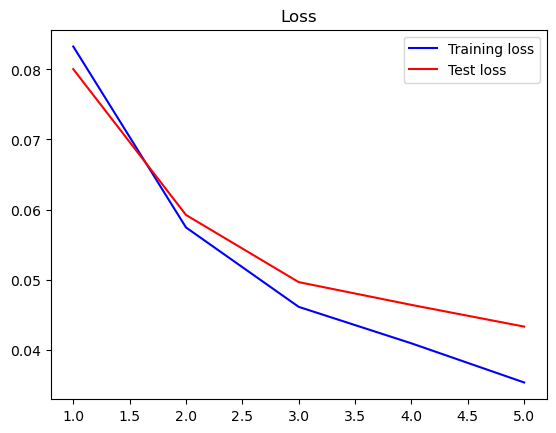

In [19]:
import matplotlib.pyplot as plt
epochs = range(1, epoch_repeat + 1)

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Loss')
plt.legend()
plt.show()

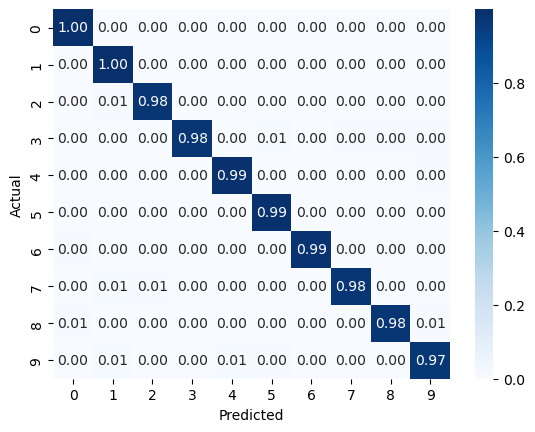

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = cnn.predict(test_set.images.reshape(10000, 1, 28, 28))
y_true = test_set.labels.reshape(10000, -1)

y_pred_decoded = np.argmax(y_pred, axis=1)
y_true_decoded = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true_decoded, y_pred_decoded)

row_sums = cm.sum(axis=1, keepdims=True)
norm_cm = cm / row_sums

sns.heatmap(norm_cm, cmap="Blues", annot=True, fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

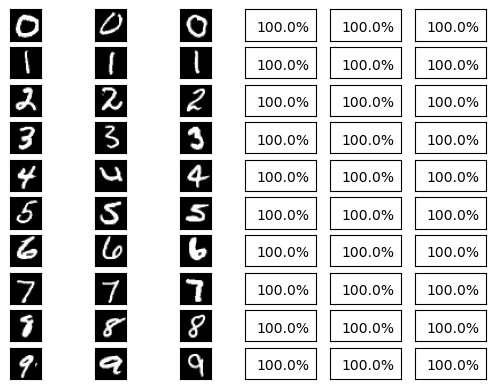

In [21]:
sorted_indices = np.argsort(y_pred, axis=0)[::-1]

for num in range(10):
    for counter in range(3):
        plt.subplot(10, 6, 6 * num + counter + 1)
        plt.imshow(test_set.images[sorted_indices[counter][num]][0], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(10, 6, 6 * num + counter + 4)
        plt.xticks([])
        plt.yticks([])
        plt.text(0.15, 0.3, f"{np.max(y_pred[sorted_indices[counter][num]], axis=0) * 100}%")
plt.show()